In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import ensemble

# Read the data

In [2]:
database_path = os.path.join('..', 'data', 'Ana', 'database', 'Garmin-Ana-180226-1.csv')
print(os.path.abspath(database_path))

D:\Data Science\GarminDataAnalyser\data\Ana\database\Garmin-Ana-180226-1.csv


In [3]:
data = pd.read_csv(database_path)
data.columns = [s.replace('_', ' ') for s in data.columns]
data = data.set_index('file name')

In [4]:
data.head()

,sport,activity,gear,comments,avg speed,total distance,total elapsed time,avg heart rate,max heart rate,avg cadence,max cadence,start position long,start position lat,end position long,end position lat,total calories,timezone,start time
file name,,,,,,,,,,,,,,,,,,
1728137024,walking,Sightseeing,Decathlon Hiking Shoes,NaN,0.956,2775.23,3084.0,115.0,146,59.0,63.0,168053069.0,553185891.0,168292581.0,553232371.0,354,0 days 02:00:00.000000000,11/05/2017 17:43
1728137508,walking,Sightseeing,Decathlon Hiking Shoes,NaN,1.280,2097.02,1705.0,127.0,141,58.0,63.0,168298219.0,553221863.0,168025784.0,553193225.0,194,0 days 02:00:00.000000000,11/05/2017 20:38
1728898008,walking,Sightseeing,Decathlon Hiking Shoes,NaN,0.563,7962.63,16177.0,117.0,159,58.0,124.0,168051965.0,553171763.0,168334170.0,553176801.0,1375,0 days 02:00:00.000000000,12/05/2017 07:49
1729258358,walking,Sightseeing,Decathlon Hiking Shoes,NaN,1.025,3549.42,3990.0,107.0,142,56.0,64.0,168227224.0,553215197.0,168022353.0,553191044.0,329,0 days 02:00:00.000000000,12/05/2017 15:32
1729605097,walking,Sightseeing,Decathlon Hiking Shoes,NaN,0.463,3604.24,9650.0,104.0,159,56.0,121.0,168038201.0,553155633.0,168021318.0,553188239.0,698,0 days 02:00:00.000000000,12/05/2017 17:14


In [5]:
data.shape

(874, 18)

In [6]:
data.groupby('sport').agg({'activity':'count'})

,activity
sport,
cycling,524
driving,62
hiking,16
mixed,24
other,4
running,20
squash,14
train,11
walking,185


# Filter the data

- Choose only some sports
- Choose only some columns as they are not all relevant, e.g. latitude, longtiude, timezone
- Deal with NaN values in the cadence columns by training two models:
    - One model will deal with activities with contain cadence data.
    - The other model will deal with activities which do NOT contain cadence data.
- There are many more cycling activities than any other sport. This might bias the model.

In [7]:
data = data[data['sport'].isin(['cycling', 'walking', 'running', 'hiking', 'driving', 'train', 'squash', 'yoga'])].copy()

In [8]:
data.groupby('sport').agg({'activity':'count'})

,activity
sport,
cycling,524
driving,62
hiking,16
running,20
squash,14
train,11
walking,185
yoga,9


In [9]:
# these are the columns we want to use for the machine learning model
columns = ['avg speed', 'total distance', 'total elapsed time', 'avg heart rate', 'max heart rate', 
           'avg cadence', 'max cadence', 'total calories']

In [10]:
# for column in ['avg cadence', 'max cadence']:
#     data[column] = data[column].fillna(data[column].mean()) # fill cadence NaNs with the average of that column
#     data[column] = data[column].fillna(0) # fill NaN values with 0 (this is not ideal as cadence values are typically 50-60)

In [11]:
data = data.dropna(axis=0, subset=['avg cadence', 'max cadence']) # drop rows in which the cadence is NaN

In [12]:
# data = data[data['avg cadence'].isna()] # keep rows in which the cadence is NaN
# data = data.dropna(axis=1) # remove columns with NaN values (should be just the cadence columns)

In [13]:
data.groupby('sport').agg({'activity':'count'})

,activity
sport,
cycling,172
hiking,16
running,20
squash,14
walking,184
yoga,9


# Scale and encode the data

In [14]:
features = data[list(set(columns) & set(data.columns))].copy()

In [15]:
features.shape

(415, 8)

In [16]:
features_scaler = preprocessing.MinMaxScaler()
# features_scaler = preprocessing.StandardScaler()

In [17]:
features_scaler.fit(features)

d:\data science\garmindataanalyser\venv36\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [18]:
sports = data['sport'].copy()

In [19]:
sports_encoder = preprocessing.LabelEncoder()

In [20]:
sports_encoder.fit(sports)

LabelEncoder()

# Split the data

In [21]:
features_train, features_test, sports_train, sports_test = model_selection.train_test_split(features, sports)

# Train the model

In [22]:
# sport_classifier = tree.DecisionTreeClassifier()
sport_classifier = ensemble.RandomForestClassifier(n_estimators=10)

In [23]:
sport_classifier.fit(features_scaler.transform(features_train), sports_encoder.transform(sports_train))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Test the model

In [24]:
predictions = features_test.copy()
predictions['real sport'] = sports_test
predictions['predicted sport'] = sports_encoder.inverse_transform(
    sport_classifier.predict(features_scaler.transform(features_test)))

# add columns indicating the probabilities for each sport
probablities = sport_classifier.predict_proba(features_scaler.transform(features_test))
for i, column in enumerate(['%s probability' % s for s in sports_encoder.classes_]):
    predictions[column] = probablities[:, i]

# only keep rows in which the prediction was wrong
predictions = predictions[predictions['real sport'] != predictions['predicted sport']] 

# predictions = predictions.sort_values('cycling probability', ascending=False)
# predictions = predictions[predictions['cycling probability'] < 1]

predictions.head(20)

,avg heart rate,total elapsed time,total distance,avg cadence,total calories,avg speed,max cadence,max heart rate,real sport,predicted sport,cycling probability,hiking probability,running probability,squash probability,walking probability,yoga probability
file name,,,,,,,,,,,,,,,,
1886155872,118.00,14592.000,10126.47,57.00,1416,0.837000,108.0,169,hiking,walking,0.0,0.3,0.0,0.0,0.7,0.0
1878465263,105.00,7533.000,6139.66,58.00,639,1.222000,79.0,147,hiking,walking,0.0,0.2,0.0,0.0,0.8,0.0
1861089501,116.00,18304.000,15662.79,58.00,1613,0.916000,107.0,173,walking,hiking,0.0,0.5,0.0,0.0,0.5,0.0
2383089922,104.95,445.000,1088.00,53.34,38,2.302222,75.0,136,cycling,walking,0.2,0.0,0.0,0.0,0.8,0.0
2481744142,110.00,568.379,869.92,59.00,37,1.531000,86.0,133,cycling,walking,0.3,0.0,0.0,0.0,0.7,0.0
1937305702,116.00,3828.949,2063.27,58.00,381,0.539000,106.0,168,squash,walking,0.0,0.2,0.1,0.1,0.6,0.0
1965219338,119.00,3510.209,1447.90,58.00,368,0.412000,114.0,147,squash,walking,0.0,0.0,0.0,0.2,0.8,0.0
1874746565,124.00,2668.000,4049.59,55.00,303,1.597000,79.0,161,hiking,cycling,0.6,0.0,0.0,0.1,0.3,0.0
2013174470,93.00,3226.260,344.04,58.00,193,0.107000,63.0,141,yoga,walking,0.0,0.0,0.0,0.0,0.7,0.3


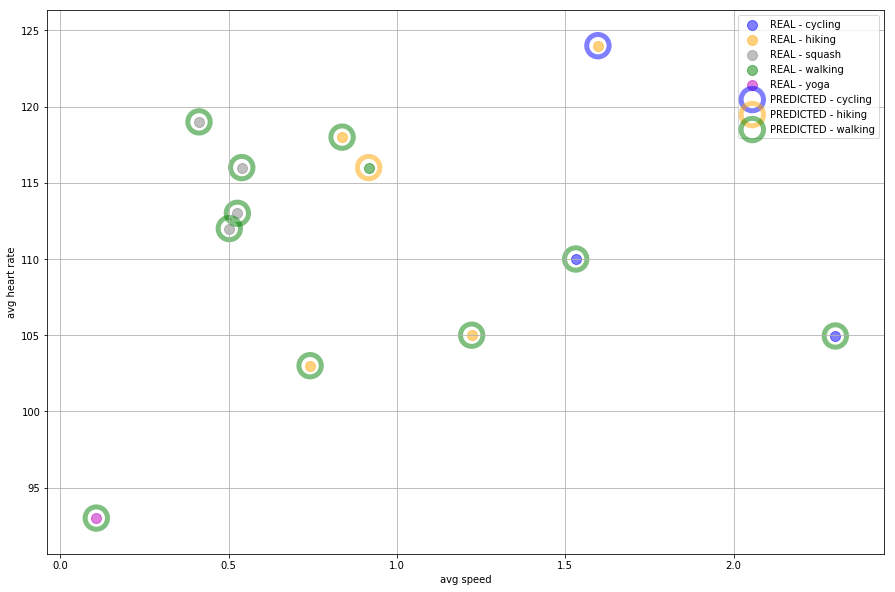

In [25]:
x = 'avg speed'
y = 'avg heart rate'
sport_colours = {'walking': 'g', 'cycling': 'b', 'driving': 'k', 'yoga': 'm', 'mixed':'y', 
                 'hiking': 'orange', 'running': 'r', 'train': 'c', 'other': 'purple', 'squash': 'grey',
                 'water': 'pink'}

fig, ax = plt.subplots(1, 1, figsize=[15,10])

for sport in sorted(predictions['real sport'].unique()):
    ax.scatter(predictions[predictions['real sport'] == sport][x], 
               predictions[predictions['real sport'] == sport][y],
               marker='o', s=100, alpha=0.5,
               color=sport_colours[sport],
               label="REAL - %s" % sport)
    
for sport in sorted(predictions['predicted sport'].unique()):
    ax.scatter(predictions[predictions['predicted sport'] == sport][x], 
               predictions[predictions['predicted sport'] == sport][y],
               marker='o', s=500, alpha=0.5, linewidth=5,
               color=sport_colours[sport], facecolors='none',
               label="PREDICTED - %s" % sport)

ax.set_xlabel(x)
ax.set_ylabel(y)
# ax.set_xlim([0,5])
# ax.set_ylim([0,5000])
ax.legend()
ax.grid()

In [26]:
sport_classifier.score(features_scaler.transform(features_test), sports_encoder.transform(sports_test))

0.8846153846153846